In [1]:
example_file_maxquant = "../../test_data/system_tests/organellar_maps/evidence.txt.maxquant_evidence_benchmark.aq_reformat.tsv"
protein_groups_file = "../../test_data/system_tests/organellar_maps/proteinGroups.txt"

In [2]:
extremes_maxlfq = ["AVEN", "HERC2", "FAM192A", "ASAH1"]
extremes_directlfq = ["AVEN", "ALDH18A1", "FAM192A", "COG5"]
extremes_locations = ["right", "bottom", "left", "top"]

In [3]:
import pandas as pd
def find_protid_by_genename(protein_groups_file, gene_name):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t", usecols = ["id", "Gene names"])
    gene2id_dict = dict(zip( protein_groups_df["Gene names"],protein_groups_df["id"]))
    return gene2id_dict.get(gene_name)


protid = find_protid_by_genename(protein_groups_file, "AVEN")
print(protid)

6270


In [4]:
import pandas as pd
mq_df = pd.read_csv(example_file_maxquant, sep = "\t")
display(max(mq_df["protein"]))

'999'

In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import directlfq.utils as lfq_utils
import directlfq.visualizations as lfq_viz
import directlfq.protein_intensity_estimation as lfq_protint

def load_mq_dataframe(example_mq_file):
    mq_df = pd.read_csv(example_mq_file, sep = "\t")
    mq_df = lfq_utils.index_and_log_transform_input_df(mq_df)
    mq_df = mq_df.reindex(sorted(mq_df.columns, key= lambda x : get_fraction_number(x)), axis=1)
    return mq_df

def load_protein_groups_df(protein_groups_file):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t")
    protein_groups_df = protein_groups_df.set_index("Gene names")
    protein_groups_lfq_columns = [x for x in protein_groups_df.columns if x.startswith("LFQ")]
    protein_groups_df_subset = protein_groups_df[protein_groups_lfq_columns]
    protein_groups_df_subset_logged = protein_groups_df_subset.replace(0, np.nan).apply(np.log2)
    protein_groups_df_subset_logged = protein_groups_df_subset_logged.reindex(sorted(protein_groups_df_subset_logged.columns, key= lambda x : get_fraction_number(x)), axis=1)
    return protein_groups_df_subset_logged

def get_fraction_number(fraction_name):
    shortened_fraction = fraction_name.split("_")[1].replace("K", "")
    try:
        return int(shortened_fraction)
    except:
        return np.inf

def get_adapted_maxlfq_values(comp_plotter, protein_groups_df, gene_of_interest):
    median_list_directlfq = lfq_protint.get_list_with_protein_value_for_each_sample(comp_plotter._protein_df_after_norm, min_nonan=1)
    maxlfq_values = protein_groups_df.loc[[gene_of_interest]].values[0]
    return (shift_maxlfq_to_median_directlfq(maxlfq_values, median_list_directlfq))

def shift_maxlfq_to_median_directlfq(maxlfq_values, directlq_values):
    shift = np.nanmedian(directlq_values - maxlfq_values)
    return maxlfq_values + shift


mq_df = load_mq_dataframe(example_file_maxquant)
protein_groups_df = load_protein_groups_df(protein_groups_file)


def compare_maxquant_and_directlfq(mq_df, protein_groups_df, gene_of_interest):
    fig, axes = plt.subplots(1, 3, figsize = (15, 5))
    selected_prot = find_protid_by_genename(protein_groups_file, gene_of_interest)
    lfq_viz.IonTraceCompararisonPlotter(mq_df, str(selected_prot), axis_unnormed=axes[0], axis_normed=axes[1])
    axes[1].get_lines()[-1].remove()
    comp_plotter = lfq_viz.IonTraceCompararisonPlotter(mq_df, str(selected_prot), axis_unnormed=axes[0], axis_normed=axes[2])
    maxlfq_values = get_adapted_maxlfq_values(comp_plotter, protein_groups_df, gene_of_interest)
    sns.lineplot(x = range(len(maxlfq_values)), y = maxlfq_values, ax=axes[2],color='green', linewidth=3, linestyle='dashed')
    lines = axes[2].get_lines()
    lines[-1].set_label("MaxLFQ")
    lines[-2].set_label("directLFQ")
    lines[-2].set_linestyle("--")
    lines[-2].set_color("darkblue")
    axes[2].legend(loc = "upper left")

    #set all y axes to the same limits
    max_y = max([max(x.get_ylim()) for x in axes])
    min_y = min([min(x.get_ylim()) for x in axes])
    for ax in axes:
        ax.set_ylim(min_y, max_y)
    

#re order figure along the x axis


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_51273/3921394756.py:16: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t")


/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/const

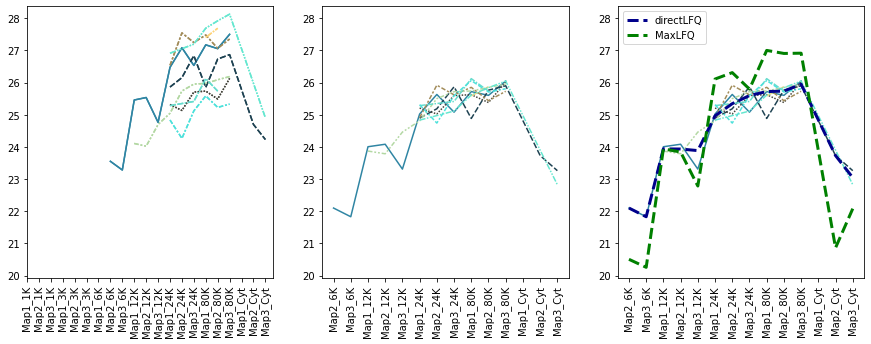

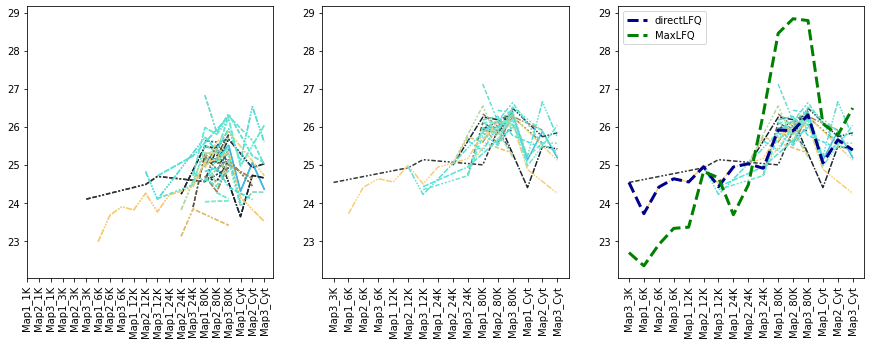

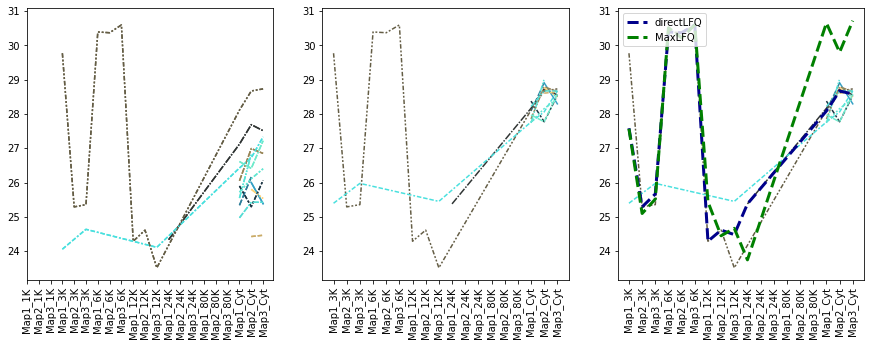

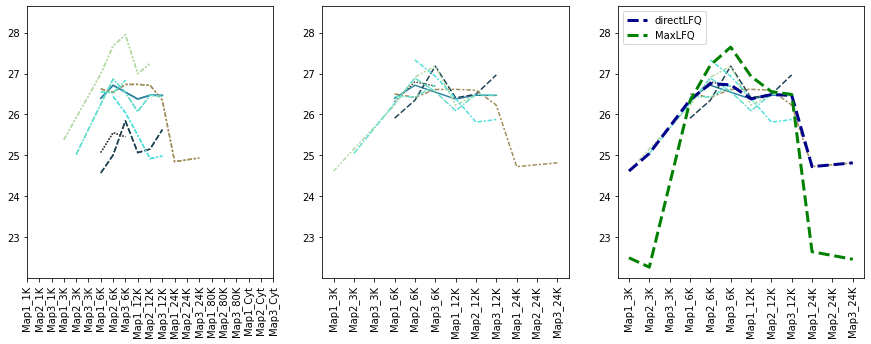

In [6]:
for gene_name in extremes_maxlfq:
    compare_maxquant_and_directlfq(mq_df, protein_groups_df, gene_name)

/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/const

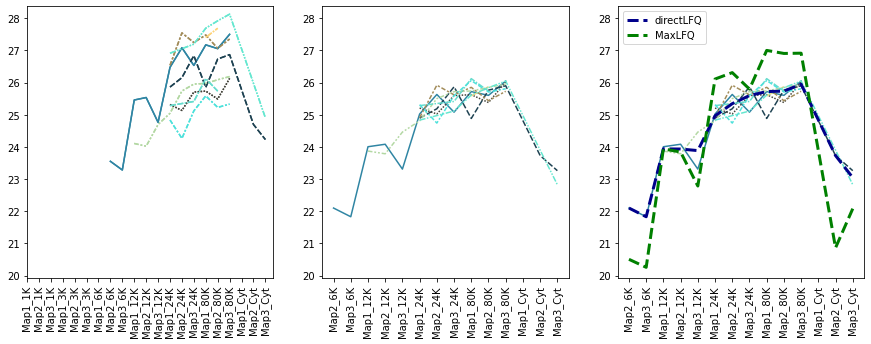

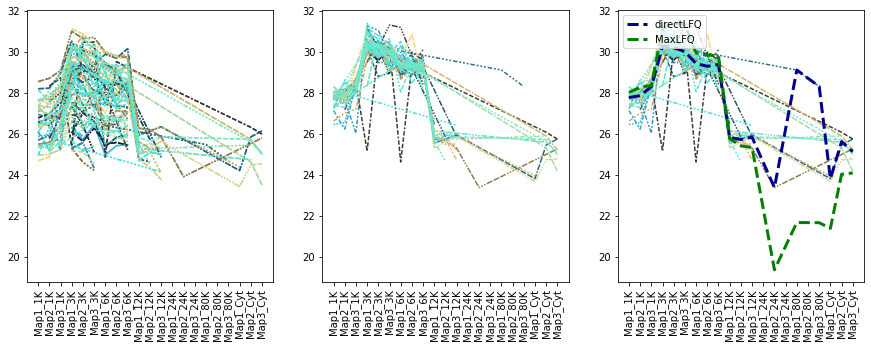

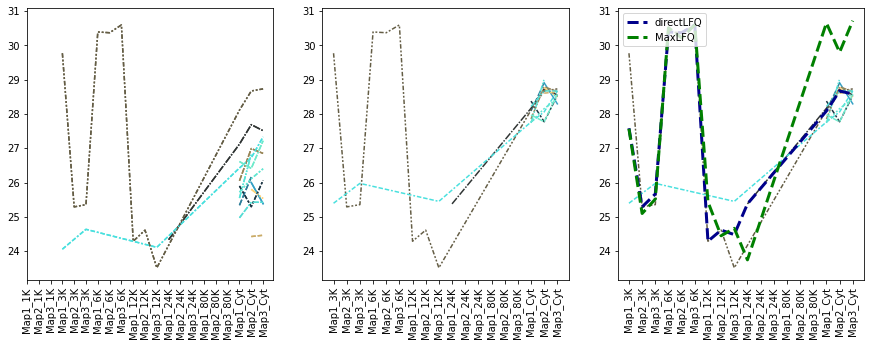

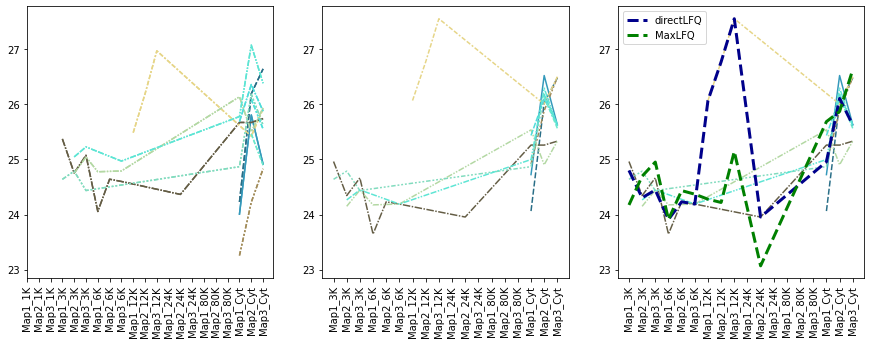

In [7]:
for gene_name in extremes_directlfq:
    compare_maxquant_and_directlfq(mq_df, protein_groups_df, gene_name)

In [6]:


plt.show()
#lfq_viz.IonTraceVisualizer(protein_df_aven, ax=plt.subplot())
